# Machine Learning Fundamentals

Today we will implement two simple content-based recommender systems. During the semester we will have a lecture on recommender systems where we look in depth about content-based and collaborative filtering recommender systems.

The main goal of this exercise is to get an understanding why similarities and normalization are very important for Machine Learning. 

In [5]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
import skimage.io

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import ipywidgets as widgets

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stofers/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/stofers/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/stofers/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Exercise 2 - Simple recommender system for wine based on similarities

We move now from cars to wine.
On Kaggle there exists a popular [dataset](https://www.kaggle.com/zynicide/wine-reviews) which consists of 130'000 wine reviews. We want to build a recommender system that recommends us a wine based on its description. 

### Prepare the dataset

In [6]:
df = pd.read_csv("winemag-data-10k.csv")
df.head()

,description,title
0,"Aromas include tropical fruit, broom, brimston...",Nicosia 2013 Vulkà Bianco (Etna)
1,"This is ripe and fruity, a wine that is smooth...",Quinta dos Avidagos 2011 Avidagos Red (Douro)
2,"Tart and snappy, the flavors of lime flesh and...",Rainstorm 2013 Pinot Gris (Willamette Valley)
3,"Pineapple rind, lemon pith and orange blossom ...",St. Julian 2013 Reserve Late Harvest Riesling ...
4,"Much like the regular bottling from 2012, this...",Sweet Cheeks 2012 Vintner's Reserve Wild Child...


Next we will check if the dataset contains any duplicates. And since the dataset contains duplicates, we will remove them and check again for duplicates.

In [7]:
print('dataset contains duplicates: %s' % df.duplicated().any())
print('len dataset: %s' % str(len(df)))
df.drop_duplicates(inplace=True)
print('dataset contains duplicates (after cleaning): %s' % df.duplicated().any())
print('len dataset (after cleaning): %s' % str(len(df)))

dataset contains duplicates: True
len dataset: 10010
dataset contains duplicates (after cleaning): False
len dataset (after cleaning): 9970


Since the text in the dataset, both for the description and the title contains upper and lower case letters, it is good to convert it to a similar format, such as both to lower case. This is specifically needed for the next step, where we will remove all of the stopwords according to a dictionary. If we would not convert the text to lowercase, we might miss removing some of the words.

In [8]:
df['description'] = df['description'].str.lower()
df['title'] = df['title'].str.lower()
df.head()

,description,title
0,"aromas include tropical fruit, broom, brimston...",nicosia 2013 vulkà bianco (etna)
1,"this is ripe and fruity, a wine that is smooth...",quinta dos avidagos 2011 avidagos red (douro)
2,"tart and snappy, the flavors of lime flesh and...",rainstorm 2013 pinot gris (willamette valley)
3,"pineapple rind, lemon pith and orange blossom ...",st. julian 2013 reserve late harvest riesling ...
4,"much like the regular bottling from 2012, this...",sweet cheeks 2012 vintner's reserve wild child...


We normalize the description by tokenizing all the words and then applying lemmatization and stemming.

In [9]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    
def normalize(text):
    tokens = nltk.word_tokenize(text)
    result = [lemmatize_stemming(token) for token in tokens 
              if token not in stop_words and len(token) > 3]
    return result

df["normalized"] = df.description.apply(lambda x: normalize(x))

Now our dataset looks like this.

In [10]:
df.head()

,description,title,normalized
0,"aromas include tropical fruit, broom, brimston...",nicosia 2013 vulkà bianco (etna),"[aroma, includ, tropic, fruit, broom, brimston..."
1,"this is ripe and fruity, a wine that is smooth...",quinta dos avidagos 2011 avidagos red (douro),"[ripe, fruiti, wine, smooth, still, structur, ..."
2,"tart and snappy, the flavors of lime flesh and...",rainstorm 2013 pinot gris (willamette valley),"[tart, snappi, flavor, lime, flesh, rind, domi..."
3,"pineapple rind, lemon pith and orange blossom ...",st. julian 2013 reserve late harvest riesling ...,"[pineappl, rind, lemon, pith, orang, blossom, ..."
4,"much like the regular bottling from 2012, this...",sweet cheeks 2012 vintner's reserve wild child...,"[much, like, regular, bottl, 2012, come, acros..."


We again take some of our training data as our test set.

In [11]:
train = df.iloc[:9960]
test = df.iloc[9960:]

X_train = train["normalized"].values
X_test = test["normalized"].values

To calculate our similarities, we only consider the normalized descriptions. For the first wine in our training set it looks like this:

In [12]:
X_train[0]

['aroma',
 'includ',
 'tropic',
 'fruit',
 'broom',
 'brimston',
 'dri',
 'herb',
 'palat',
 'over',
 'express',
 'offer',
 'unripen',
 'appl',
 'citrus',
 'dri',
 'sage',
 'alongsid',
 'brisk',
 'acid']

### Define similarity

To compare two wines, we use the jaccard similarity.
> Implement the jaccard similarity

In [32]:
def jaccard_similarity(list1, list2):
    similarity = 0
    # START YOUR CODE
    intersect = set.intersection(set(list1), set(list2))
    union = set(list1 + list2)
    
    similarity = len(intersect)/len(union)
    # END YOUR CODE
    return similarity

If your code is correct, the following cell should run without an error.
> Verify your code

In [33]:
expected_similarity = 0.05405405405405406
similarity = jaccard_similarity(X_train[0], X_train[1])
print(similarity)
np.testing.assert_equal(expected_similarity, similarity)

0.05405405405405406


### Visualize similarities
We can visualize the similarity between the wines using a heatmeap. Let us show how similar the first 40 wines are. The darker the box in the heatmap, the more similar they are.

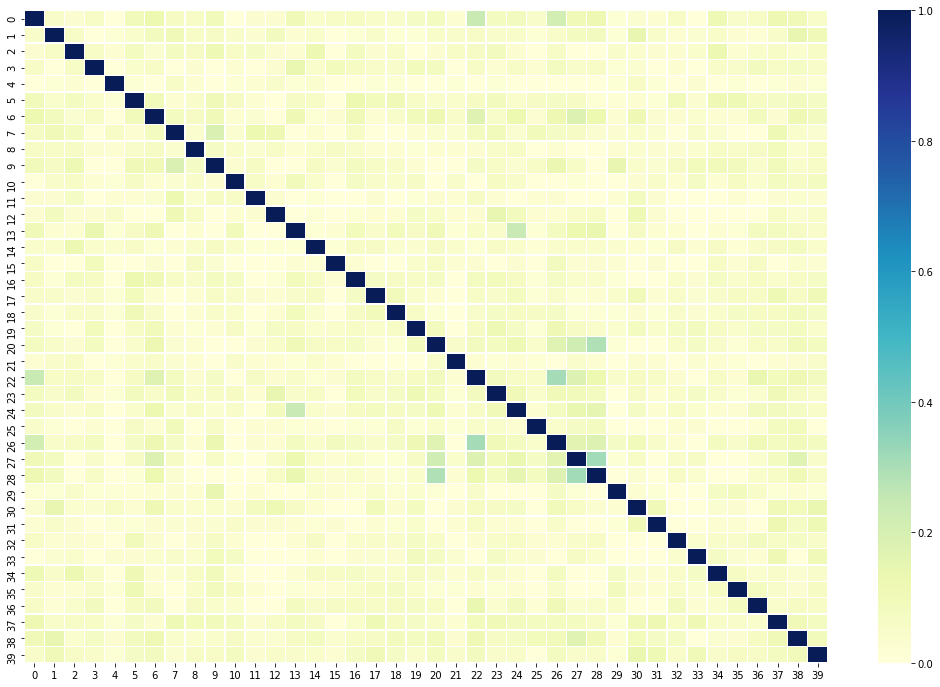

In [34]:
dm = np.asarray([[jaccard_similarity(p1, p2) 
                  for p1 in X_train[0:40]] 
                    for p2 in X_train[0:40]])
fig, ax = plt.subplots(figsize=(18,12))    
ax = sns.heatmap(dm, linewidth=0.5, cmap="YlGnBu")
plt.show()

### Find most similar wine
> Now implement the `nearest_neighbor` function, which returns the index of the most similar wine and the similarity value. *Hint: We use now a similarity measure instead of a distance measure*.

In [50]:
def nearest_neighbor(wine, wines):
    idx = -1
    similarity = -1
    #wines = set(wines)
    # START YOUR CODE
    similarities = np.asarray([jaccard_similarity(wine, w) for w in wines])
    idx = np.argmax(similarities)
    similarity = np.amax(similarities)
    # END YOUR CODE
    return idx, similarity

If your code is correct, the following cell should run without an error.

In [51]:
wine = X_test[0]

expected_similarity = 0.30303030303030304
idx, similarity = nearest_neighbor(wine, X_train)
np.testing.assert_equal(expected_similarity, similarity)

most_similar = train.iloc[[idx]]

print("Most similar wine: {}".format(most_similar.title.values[0]))
print("Similarity: ", similarity)

Most similar wine: domaine pfister 2011 tradition pinot gris (alsace)
Similarity:  0.30303030303030304


### Play around with our recommender system
We can now use our recommender system to get a wine recommendation based on its description.

In [52]:
@widgets.interact(wine_title=widgets.Dropdown(options=sorted(test.title), description="Wine title"))
def recommend(wine_title):
    wine = X_test[test["title"] == wine_title][0]
    idx, similarity = nearest_neighbor(wine, X_train)
    
    most_similar = train.iloc[[idx]]
    print("Most similar wine: '{}' with a similarity of {:2f}".format(most_similar.title.values[0], similarity))

interactive(children=(Dropdown(description='Wine title', options=('bouchard aîné & fils 2011 cuvée signature  …

## Assignment

Now answer the ILIAS quiz **Machine Learning Fundamentals**.